In [2]:
from pathlib import Path
import yaml
import numpy as np
from torch.utils.data import DataLoader

from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from hydra.utils import instantiate

import os
import torch
import sys
import pickle

sys.path.append("/home/erogullari/Workspace/cav-disentanglement")
out_dir = Path("/home/erogullari/Workspace/cav-disentanglement/media/model_correction")
results_dir = Path("/home/erogullari/Workspace/cav-disentanglement/results/model_correction/vgg16/features.29")
out_dir.mkdir(parents=True, exist_ok=True)

In [20]:
def _format_run_value(value):
    if value is None:
        return None
    if isinstance(value, str):
        return value
    return f"{value:g}"


def _select_run_dir(results_root, cav_type, alpha, lr=None):
    cav_root = Path(results_root) / cav_type
    if not cav_root.exists():
        raise FileNotFoundError(f"Missing CAV results directory: {cav_root}")
    alpha_str = _format_run_value(alpha)
    if lr is not None:
        lr_str = _format_run_value(lr)
        prefix = f"alpha{alpha_str}_lr{lr_str}_"
    else:
        prefix = f"alpha{alpha_str}_lr"
    matches = sorted(
        [p for p in cav_root.iterdir() if p.is_dir() and p.name.startswith(prefix)]
    )
    if not matches:
        raise FileNotFoundError(
            f"No runs found for {cav_type} with alpha={alpha_str} (lr={lr})."
        )
    if len(matches) > 1:
        matches = sorted(matches, key=lambda p: p.stat().st_mtime, reverse=True)
        print(
            f"Multiple runs found for {cav_type} alpha={alpha_str}. "
            f"Using most recent: {matches[0].name}"
        )
    return matches[0]


def _load_accuracy(run_dir, split):
    metrics_path = Path(run_dir) / "results" / "metrics_per_model.pkl"
    if not metrics_path.exists():
        raise FileNotFoundError(f"Missing metrics file: {metrics_path}")
    with open(metrics_path, "rb") as f:
        metrics = pickle.load(f)
    accuracy_key = f"test_accuracy_{split}"
    try:
        vanilla = metrics["vanilla"][accuracy_key]
        baseline = metrics["baseline"][accuracy_key]
        orthogonal = metrics["orthogonal"][accuracy_key]
    except KeyError as exc:
        raise KeyError(
            f"Missing '{accuracy_key}' in {metrics_path}."
        ) from exc
    return vanilla, baseline, orthogonal


def plot_model_correction_accuracies(
    pattern_alpha,
    multi_alpha,
    *,
    pattern_lr=None,
    multi_lr=None,
    results_root=results_dir,
    title=None,
    save_path=None,
):
    """Plot vanilla vs baseline vs orthogonal accuracies for pattern and multi CAVs."""
    results_root = Path(results_root)
    pattern_dir = _select_run_dir(results_root, "pattern_cav", pattern_alpha, lr=pattern_lr)
    multi_dir = _select_run_dir(results_root, "multi_cav", multi_alpha, lr=multi_lr)

    pattern_scores = {
        split: _load_accuracy(pattern_dir, split)
        for split in ("attacked", "clean")
    }
    multi_scores = {
        split: _load_accuracy(multi_dir, split)
        for split in ("attacked", "clean")
    }

    groups = ["attacked", "clean"]
    labels = [
        "Vanilla",
        "Pattern CAV",
        "Pattern Orth",
        "Multi CAV",
        "Multi Orth",
    ]
    values = []
    for split in groups:
        p_vanilla, p_base, p_orth = pattern_scores[split]
        m_vanilla, m_base, m_orth = multi_scores[split]
        values.append([p_vanilla, p_base, p_orth, m_base, m_orth])

    x = np.arange(len(groups))
    width = 0.14
    offsets = np.linspace(-2, 2, len(labels)) * width

    fig, ax = plt.subplots(figsize=(8, 4.5))
    for idx, label in enumerate(labels):
        ax.bar(x + offsets[idx], [row[idx] for row in values], width, label=label)

    ax.set_xticks(x)
    ax.set_xticklabels(["Attacked", "Clean"])
    ax.set_ylabel("Accuracy")
    ax.set_ylim(0, 1)
    ax.set_title(title or "Model correction accuracy")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.18), ncol=3)
    fig.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()

    return {
        "pattern": pattern_scores,
        "multi": multi_scores,
        "pattern_dir": pattern_dir,
        "multi_dir": multi_dir,
    }


def _load_concept_relevance(run_dir):
    rel_path = Path(run_dir) / "results" / "concept_relevance.pkl"
    if not rel_path.exists():
        raise FileNotFoundError(f"Missing concept relevance file: {rel_path}")
    with open(rel_path, "rb") as f:
        rel_data = pickle.load(f)
    rows = []
    for key, value in rel_data.items():
        if not key.startswith("concept_rel_"):
            continue
        name = key[len("concept_rel_"):]
        if "_" in name:
            concept, cav = name.rsplit("_", 1)
        else:
            concept, cav = name, "Unknown"
        try:
            val = float(value)
        except Exception:
            val = float(value.item())
        rows.append((concept, cav, val))
    if not rows:
        raise ValueError(f"No concept relevance entries found in {rel_path}")
    return rows


def plot_concept_relevances(
    pattern_alpha,
    multi_alpha,
    *,
    pattern_lr=None,
    multi_lr=None,
    results_root=results_dir,
    title=None,
    save_path=None,
    concept="timestamp",
):
    """Plot concept relevances for pattern and multi CAV runs in one bar chart."""
    results_root = Path(results_root)
    pattern_dir = _select_run_dir(results_root, "pattern_cav", pattern_alpha, lr=pattern_lr)
    multi_dir = _select_run_dir(results_root, "multi_cav", multi_alpha, lr=multi_lr)

    label_map = {"Baseline": "Baseline", "Orthogonal": "Orth"}

    def format_label(prefix, cav):
        return f"{prefix} {label_map.get(cav, cav)}"

    values = {}
    for concept_name, cav, val in _load_concept_relevance(pattern_dir):
        label = format_label("Pattern", cav)
        values.setdefault(concept_name, {})[label] = val
    for concept_name, cav, val in _load_concept_relevance(multi_dir):
        label = format_label("Multi", cav)
        values.setdefault(concept_name, {})[label] = val

    if concept is not None:
        if concept not in values:
            raise ValueError(f"Concept '{concept}' not found in concept relevance data.")
        values = {concept: values[concept]}

    base_labels = [
        "Pattern Baseline",
        "Pattern Orth",
        "Multi Baseline",
        "Multi Orth",
    ]
    extra_labels = sorted({label for v in values.values() for label in v} - set(base_labels))
    labels = base_labels + extra_labels

    concepts = list(values.keys())
    x = np.arange(len(concepts))
    width = 0.8 / max(len(labels), 1)
    offsets = (np.arange(len(labels)) - (len(labels) - 1) / 2) * width

    fig, ax = plt.subplots(figsize=(max(4, len(concepts) * 1.4), 4.5))
    for idx, label in enumerate(labels):
        heights = [values[c].get(label, np.nan) for c in concepts]
        ax.bar(x + offsets[idx], heights, width, label=label)

    ax.set_xticks(x)
    ax.set_xticklabels([c.replace("_", " ") for c in concepts])
    ax.set_ylabel("Concept Relevance")
    ax.set_ylim(0, 1)
    ax.set_title(title or "Concept relevance comparison")
    ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.22), ncol=2)
    fig.tight_layout()

    if save_path is not None:
        save_path = Path(save_path)
        save_path.parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path, bbox_inches="tight")
    plt.show()

    return {
        "pattern_dir": pattern_dir,
        "multi_dir": multi_dir,
        "values": values,
    }


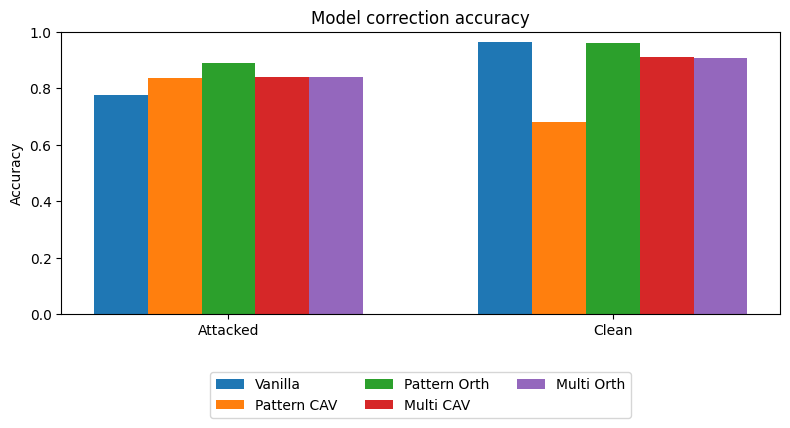

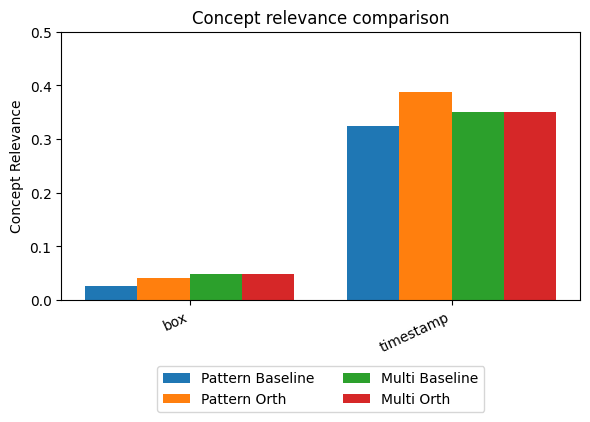

{'pattern_dir': PosixPath('/home/erogullari/Workspace/cav-disentanglement/results/model_correction/vgg16/features.29/pattern_cav/alpha1_lr1e-05_opt'),
 'multi_dir': PosixPath('/home/erogullari/Workspace/cav-disentanglement/results/model_correction/vgg16/features.29/multi_cav/alpha0.1_lr1e-05_opt'),
 'values': {'timestamp': {'Pattern Baseline': 0.32461586594581604,
   'Pattern Orth': 0.38733911514282227,
   'Multi Baseline': 0.3503154516220093,
   'Multi Orth': 0.349312424659729},
  'box': {'Pattern Baseline': 0.02611381560564041,
   'Pattern Orth': 0.04022134467959404,
   'Multi Baseline': 0.04822825640439987,
   'Multi Orth': 0.04837460815906525}}}

In [21]:
pattern_alpha = "1"
pattern_lr = "1e-05"
multi_alpha = "0.1"
multi_lr = "1e-05"
split = "attacked"

plot_model_correction_accuracies(
    pattern_alpha,
    multi_alpha,
    pattern_lr=pattern_lr,
    multi_lr=multi_lr,
    save_path=out_dir / f"acc_split_{split}_alpha{pattern_alpha}_lr{pattern_lr}_multi_alpha{multi_alpha}_multi_lr{multi_lr}.png",
)

plot_concept_relevances(
    pattern_alpha,
    multi_alpha,
    pattern_lr=pattern_lr,
    multi_lr=multi_lr,
    save_path=out_dir / f"concept_relevance_alpha{pattern_alpha}_lr{pattern_lr}_multi_alpha{multi_alpha}_multi_lr{multi_lr}.png",
)